Download and Explore the Dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', with_info=True)


Explore Dataset:

Inspect the dataset to understand its structure, including the number of classes, image sizes, and annotations.

In [ ]:
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

Remove Irrelevant or Low-Quality Images:

Filter out any images that are not relevant to the object detection task.
Normalize Image Sizes:

Resize images to a consistent size for model input.

Fine-tune on Oxford-IIIT Pet Dataset:
Fine-tune the pre-trained model on the Oxford-IIIT Pet Dataset.



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow_hub as hub

First, you need to select a pre-trained model from TensorFlow Hub. We will use the SSD MobileNet V2 as an example.

To fine-tune the pre-trained model on the Oxford-IIIT Pet Dataset, you'll need to set up the model for training.

In [ ]:

# Load a smaller dataset
def load_data(split='train'):
    dataset, info = tfds.load('oxford_iiit_pet', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Load the train dataset and extract info
train_dataset, train_info = load_data('train[:80%]')

# Load the validation dataset
validation_dataset, validation_info = load_data('test[:20%]')

# Get class names
class_names = train_info.features["label"].names
print("Class names:", class_names)

# Visualize a few examples from the dataset
def visualize_data(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for i, example in enumerate(dataset.take(9)):
        image, label = example["image"], example["label"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()



Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


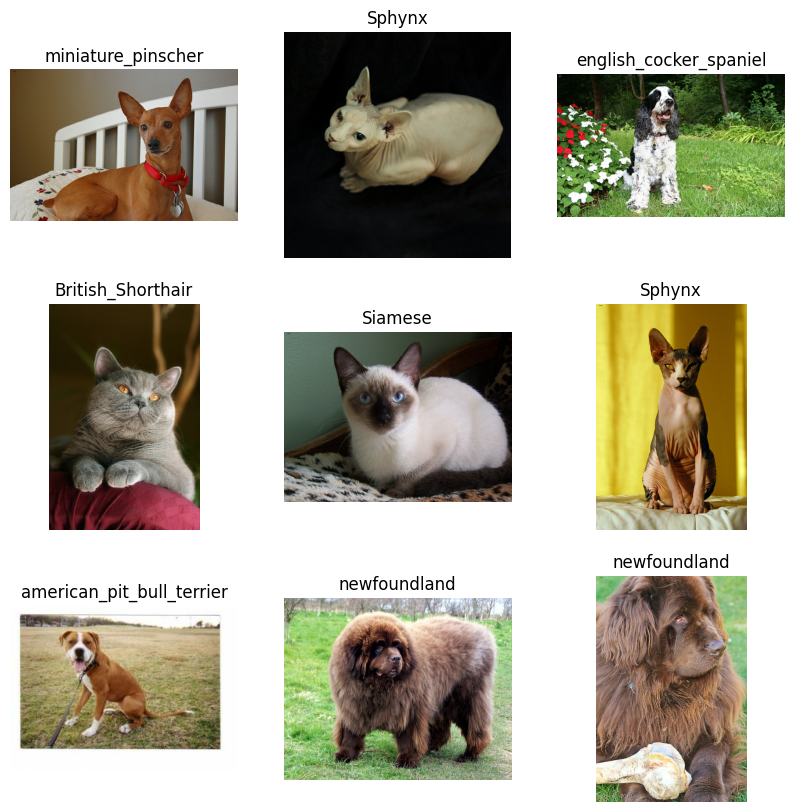

In [ ]:
# Function to display examples
def display_examples(dataset, class_names, n=3):  # Display 'n' examples by default
    for example in dataset.take(n):
        # Extract image and label from the tuple (assuming it's a tuple of two elements)
        image, label = example
        label = label.numpy()  # Convert label to numpy for displaying
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
        plt.show()

# (Rest of your code remains the same)
# Visualize some training examples
visualize_data(train_dataset, class_names)


In [ ]:
#Load a pre-trained object detection model
import tensorflow_hub as hub # Import the tensorflow_hub module
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

In [ ]:


#Function to run the detector and visualize results
def run_detector_and_visualize(image, class_names):
    # Preprocess and run detection
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    # Visualize results
    plt.figure(figsize=(10, 5))
    plt.imshow(image)

    # Predicted boxes
    for i, score in enumerate(result['detection_scores'][0]):
        if score > 0.5:  # Confidence threshold
            ymin, xmin, ymax, xmax = result['detection_boxes'][0][i]
            class_id = int(result['detection_classes'][0][i])

            # Handle invalid class IDs (classes outside the dataset)
            if class_id < len(class_names):
                label = class_names[class_id]
            else:
                label = "Unknown"

            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='r', facecolor='none', label='Predicted')
            plt.gca().add_patch(rect)

            plt.text(xmin * image.shape[1], ymin * image.shape[0] - 5, f'{label}: {score:.2f}', color='white', backgroundcolor='r')

    plt.legend()
    plt.axis('off')
    plt.show()




In [ ]:
# Display some examples from the train dataset
for example in train_dataset.take(9):  # Process 9 images
    image = example["image"]
    run_detector_and_visualize(image, class_names) # pass the class_names to the function

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Function to run the detector and get the highest confidence prediction
def get_prediction(image):
    # Preprocess and run detection
    # Convert image to uint8 before passing it to convert_image_dtype
    image = tf.cast(image, tf.uint8)
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)


In [ ]:
# Function to calculate accuracy based on class labels
def evaluate_model_performance(dataset, detector, num_samples=100):
    correct_predictions = 0
    total_predictions = 0

    for example in dataset.take(num_samples):
        image = example["image"].numpy()
        gt_label = example["label"].numpy()

        # Preprocess and run detection
        converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        pred_labels = result['detection_classes'][0].astype(int)
        pred_scores = result['detection_scores'][0]

        # Use the top prediction for evaluation
        top_pred_label = pred_labels[0]
        top_pred_score = pred_scores[0]

        # Check if the top prediction matches the ground truth label
        if top_pred_label == gt_label:
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"Model Accuracy: {accuracy:.2f}")

# Evaluate model performance
print("Evaluating model performance...")
evaluate_model_performance(validation_dataset, detector)  # Use test data for evaluation

Evaluating model performance...
Model Accuracy: 0.03
